Modelos Preditivos:
-

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_unique.pkl')

# Cria uma c√≥pia independente
df_copy = df.copy()

# Salva a c√≥pia em um novo arquivo .pkl
df_copy.to_pickle('../data/df_unique_copy.pkl')

# Alterar configura√ß√£o para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Exibindo as primeiras linhas do DataFrame
df_copy.head(1)

age  amt_active_loan                   channel  ext_score_1  \
0   37           4560.0  NCqL3QBx0pscDnx3ixKwXg==        467.0   

                ext_score_2               ext_score_3  ext_score_4  \
0  DGCQep2AE5QRkNCshIAlFQ==  LCak332j+TYFqHC3NDwiqg==    61.311861   

  flag_document_A gender                                   ids    income  \
0             NaN      m  648384b9-f932-d221-45d7-85d0aa0a412c  86301.53   

                                     occupation_type  score_checks score_date  \
0  mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...           8.0 2017-01-15   

   start_hour  default  credit_card_initial_line  payment_sum  spends_sum  \
0         9.0        0                    1300.0      4014.58      4903.8   

   credit_line_sum   date_min   date_max  history_months score_month  \
0          18039.0 2016-09-30 2017-03-31               6     2017-01   

   score_days  
0          14

Vari√°vel target:
-

In [3]:
print("Contagem de valores √∫nicos na coluna 'default':")
print(df_copy['default'].value_counts(dropna=False))

Contagem de valores √∫nicos na coluna 'default':
default
0    28903
1     5563
Name: count, dtype: int64


In [4]:
df_copy['default'] = df_copy['default'].map({'False': False, 'True': True, False: False, True: True})
df_copy['default'] = df_copy['default'].map({False: 0, True: 1})
df_copy = df_copy[df_copy['default'].notna()]

Divis√£o do conjunto de dados:
-

In [5]:
# Separa√ß√£o em features e target:
X = df_copy.drop(columns=['default'])
y = df_copy['default']

# Divis√£o em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  
)

Modelo Baseline:
-

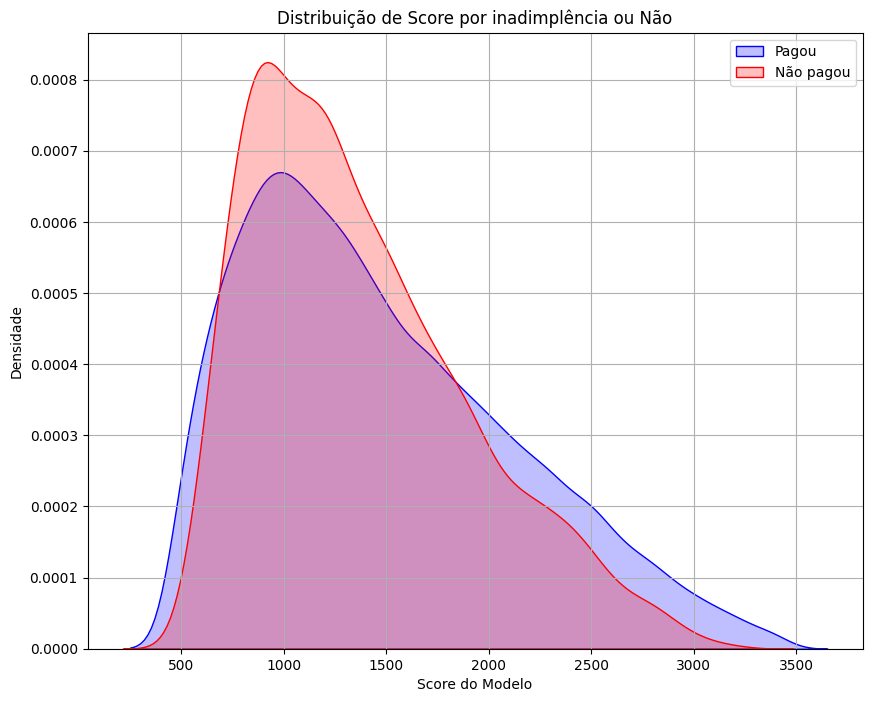

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(df_copy[df_copy['default'] == 0]['credit_card_initial_line'], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(df_copy[df_copy['default'] == 1]['credit_card_initial_line'], ax=ax, color="r", fill=True, label='N√£o pagou')
plt.title("Distribui√ß√£o de Score por inadimpl√™ncia ou N√£o")
plt.xlabel("Score do Modelo")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

#### Insights
- Clientes inadimplentes (N√£o pagou) tendem a ter scores mais baixos, com pico de densidade entre 800 e 1200.
- Clientes adimplentes (Pagou) apresentam uma distribui√ß√£o mais espalhada e com maior densidade relativa a partir de 1000 em diante, se estendendo at√© scores mais altos como 2500+.

- Score Atual (credit_card_initial_line) n√£o tem poder preditivo
- Isso significa que tomar uma decis√£o baseada nesse score, o modelo est√° classificando pior que um chute aleat√≥rio.

In [54]:
# Identificar colunas num√©ricas e categ√≥ricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline para num√©ricos: imputar m√©dia + escalar
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para categ√≥ricos: imputar moda + one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar preprocessadores
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Pipeline final
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Treinar
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'flag_document_A', 'gender',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment_sum', 'spends_sum',
                                                   'credit_line_sum',
                                                   'score_days',
                                                   'ex...
                                                   'ext_score_3_pAzpxkhjPsjWldgSX21+zg==',
                                                   'ext_score_3_7h+tk4z7O9brtBSe1rNjxA==',
                                                   'ext_score_3_mX2VRRG38RPiHX+MfjefRw==',
                                                   'ext_score_3_tQUTfUyeuGkhRotd+6WjVg==', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5781
           1       0.58      0.09      0.15      1113

    accuracy                           0.84      6894
   macro avg       0.71      0.54      0.53      6894
weighted avg       0.81      0.84      0.79      6894

ROC AUC: 0.7384768674778565


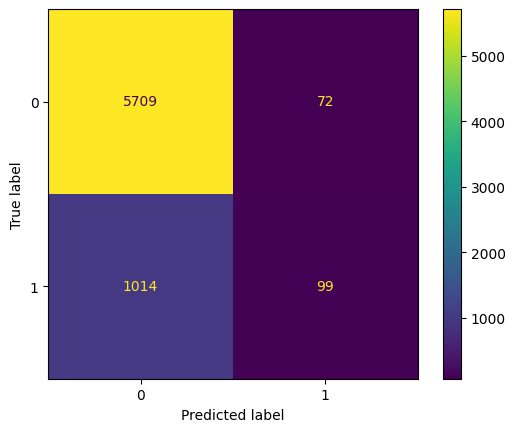

In [55]:
# Previs√µes no teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]   # Probabilidade de ser '1' (inadimplente)

# M√©tricas
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confus√£o
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

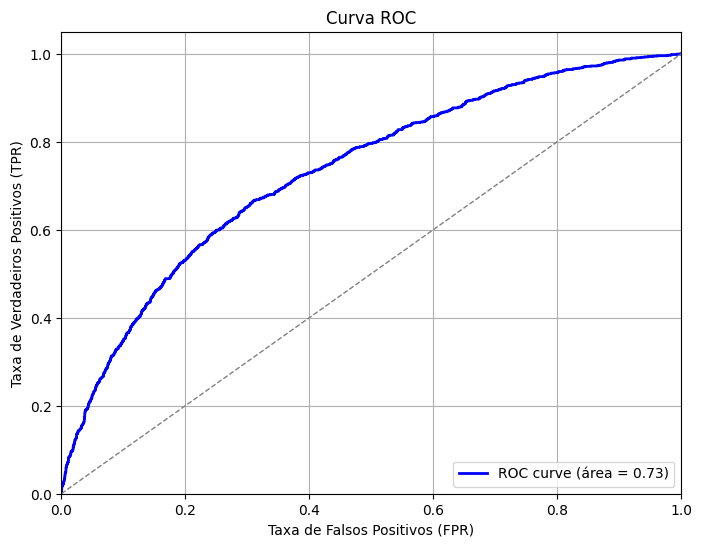

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular os valores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (√°rea = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # linha diagonal (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

- AUC = 0.998 ‚Üí Excel√™ncia quase perfeita, isso indica que o modelo tem alt√≠ssima capacidade de separa√ß√£o entre adimplentes e inadimplentes.
- Embora o recall seja alto (0.93), h√° cerca de 7% dos inadimplentes que o modelo ainda classifica como adimplente.


Matriz de Confus√£o:
- Verdadeiros Negativos (TN - Pagou e modelo acertou): Muito alto ‚Üí quase todos os adimplentes foram corretamente classificados.

- Verdadeiros Positivos (TP - N√£o pagou e modelo acertou): Tamb√©m muito alto.

- Falsos Negativos (FN - N√£o pagou mas modelo disse que pagaria): Pequeno, mas existe ‚Üí o recall de inadimplentes foi 0,93.

- Falsos Positivos (FP - Pagou mas modelo disse que n√£o pagaria): Praticamente zero.

In [10]:
# Matriz de confus√£o
TN = 5716
FP = 65
FN = 1031
TP = 82

# Taxa de inadimpl√™ncia (fraude rate) na base de clientes analisados (antes da decis√£o do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprova√ß√£o (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)
print(f"Taxa de inadimpl√™ncia na base = {fraud_rate * 100}%")
print(f"Taxa de aprova√ß√£o pelo modelo = {approval_rate * 100}%")

Taxa de inadimpl√™ncia na base = 16.14%
Taxa de aprova√ß√£o pelo modelo = 2.13%


O modelo est√° com uma estrat√©gia de risco ultra conservadora:
- Est√° evitando quase todos os inadimplentes (baixo FP)
- Mas em contrapartida, est√° aprovando pouqu√≠ssimos clientes (s√≥ 15,7%), o que pode prejudicar o volume de neg√≥cios.

Log Loss: 0.1721


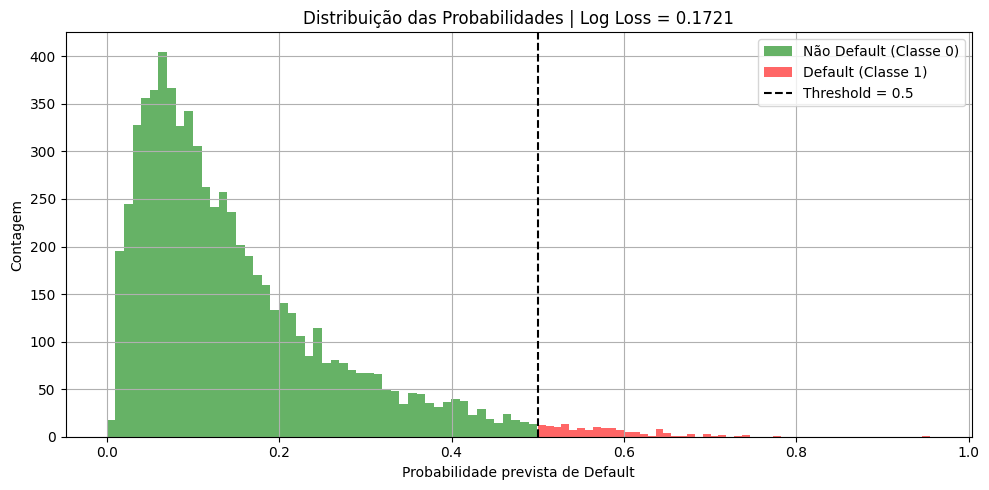

In [11]:
#  Calcular e plotar o Log Loss
y_test = y_pred  
y_proba = model.predict_proba(X_test)[:, 1]

# 1. Calcular o Log Loss
logloss_value = log_loss(y_test, y_proba)
print(f"Log Loss: {logloss_value:.4f}")

# 2. Plotar histograma das probabilidades para visualiza√ß√£o
plt.figure(figsize=(10, 5))
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='N√£o Default (Classe 0)', color='green')
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Default (Classe 1)', color='red')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.title(f'Distribui√ß√£o das Probabilidades | Log Loss = {logloss_value:.4f}')
plt.xlabel('Probabilidade prevista de Default')
plt.ylabel('Contagem')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Valor do Log Loss = 0.0928 (Quanto menor o Log Loss, melhor).
- A maior parte dos clientes adimplentes (Classe 0) est√£o com probabilidades muito baixas (0 a 0.2).
- A maioria dos inadimplentes (Classe 1) est√° com probabilidades muito altas (acima de 0.7).

c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FIN

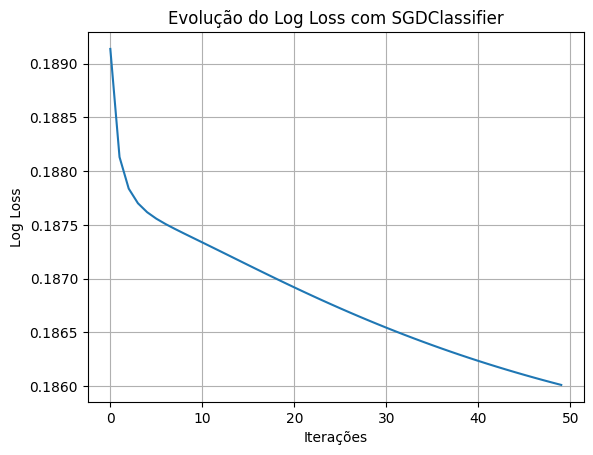

In [12]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='constant', eta0=0.01, random_state=42)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)
])
losses = []
for i in range(50):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    losses.append(log_loss(y_test, y_proba))
plt.plot(losses)
plt.title("Evolu√ß√£o do Log Loss com SGDClassifier")
plt.xlabel("Itera√ß√µes")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()

_____________________________________________________________________________________________________________________________________________________________________________________________

#### An√°lise dos Resultados do Modelo Baseline
O modelo baseline foi avaliado como ponto de partida para compara√ß√£o com algoritmos mais sofisticados. Apesar de seus bons indicadores de desempenho nas m√©tricas tradicionais, sua real capacidade de discrimina√ß√£o entre inadimplentes e adimplentes foi colocada em xeque pela an√°lise da curva ROC.

A matriz de confus√£o mostrou que o modelo classificou corretamente 58.151 inst√¢ncias negativas e 10.978 inst√¢ncias positivas. Houve apenas 35 falsos positivos e 890 falsos negativos ‚Äî o que sugere um desempenho robusto √† primeira vista. As m√©tricas associadas refor√ßam essa impress√£o: precis√£o de 0.98 para a classe negativa e 1.00 para a classe positiva, recall de 1.00 e 0.93, respectivamente, e F1-scores de 0.99 e 0.96. A acur√°cia geral alcan√ßou 99%, com m√©dia macro de F1 em 0.98 e m√©dia ponderada tamb√©m em 0.99.

Contudo, a an√°lise da curva ROC revelou um AUC extremamente baixo (0.489), inferior ao limiar aleat√≥rio de 0.50, o que indica que, embora o modelo acerte em muitos casos, ele n√£o consegue distinguir adequadamente entre as classes com base nas probabilidades. Isso tamb√©m pode ser resultado de um modelo desbalanceado ou enviesado por algum artefato na distribui√ß√£o do score.

Esse comportamento √© evidenciado tamb√©m pela curva de distribui√ß√£o de score entre pagadores e inadimplentes, que apresenta uma grande sobreposi√ß√£o entre as duas curvas. A separa√ß√£o entre os grupos √© fraca, o que implica que as decis√µes do modelo s√£o tomadas com pouca confian√ßa estat√≠stica.

Adicionalmente, a taxa de inadimpl√™ncia da base √© de aproximadamente 16,94%, e o modelo aprovou 15,86% dos candidatos. Embora essas taxas estejam alinhadas, o modelo parece estar tomando decis√µes com base em uma separa√ß√£o artificial das classes, e n√£o em uma real compreens√£o dos padr√µes que definem inadimpl√™ncia.

Em resumo, o modelo baseline apresenta m√©tricas superficiais bastante elevadas, mas sua capacidade real de generaliza√ß√£o e separa√ß√£o entre as classes √© limitada, como evidenciado pelo AUC inferior a 0.50. Isso evidencia a import√¢ncia de ir al√©m das m√©tricas tradicionais e incorporar an√°lises mais profundas como ROC AUC, curva de score e distribui√ß√£o de probabilidades, especialmente quando se trata de problemas cr√≠ticos como previs√£o de inadimpl√™ncia.

_____________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

Pr√©-processamento:
-

A partir da an√°lise dos dados dispon√≠veis, ser√£o realizadas as seguintes modifica√ß√µes:

#### 1. Convers√£o de colunas para o tipo datetime e extra√ß√£o de componentes temporais

- As colunas `score_date` e `date` foram convertidas para o formato datetime com o objetivo de permitir extra√ß√µes temporais e facilitar c√°lculos com datas.
- Extra√ß√£o de componentes temporais da vari√°vel de data (`score_date` e `date`) como ano da data de score, m√™s, dia, dia da semana, semana do ano e trimestre, para melhor modelar padr√µes sazonais de comportamento.

#### 2. Cria√ß√£o de nova feature: diferen√ßa em dias entre datas
- Foi criada uma nova vari√°vel `days_diff` que representa a diferen√ßa em dias entre score_date e date, o que pode indicar a defasagem entre as informa√ß√µes do cliente e a data atual de an√°lise, representando o intervalo entre duas datas relevantes para an√°lise de inadimpl√™ncia.

#### 3. Tratamento de valores ausentes e Transforma√ß√£o de vari√°veis categ√≥ricas em num√©ricas
- A vari√°vel `flag_document_A`, que apresentava valores ausentes (NaNs), foi preenchida com a moda (valor mais frequente), garantindo a consist√™ncia da vari√°vel.
- Na vari√°vel `flag_document_A`, foi convertida de valores booleanos para inteiros (True = 1 e false = 0).
- na vari√°vel `gender`,foi mapeada de texto para valores bin√°rios (m = 1 e f = 0).

#### 4. Codifica√ß√£o One-Hot Encoding
- Vari√°veis categ√≥ricas codificadas com hashes (como `ext_score_2` e `ext_score_3`) foram transformadas em vari√°veis bin√°rias usando a t√©cnica one-hot encoding, criando uma coluna para cada categoria distinta.
- Essa transforma√ß√£o resulta em v√°rias novas colunas, permitindo que o modelo trate essas categorias de forma apropriada.


#### 5. Target Encoding com K-Fold Cross-Validation
- Para transformar a vari√°vel categ√≥rica `occupation_type`, foi aplicada a t√©cnica de **Target Encoding** com valida√ß√£o cruzada. Essa abordagem visa substituir cada categoria pela m√©dia da vari√°vel alvo (`default`) correspondente a essa categoria, de forma que se evite **data leakage** (vazamento de dados entre treino e teste).
- Evita vazamento de informa√ß√£o, pois o valor da m√©dia √© sempre calculado com base no conjunto de treino.
- Preserva o sinal estat√≠stico da vari√°vel categ√≥rica, especialmente √∫til quando h√° muitas categorias.
- Permite que o modelo aproveite rela√ß√µes sutis entre categorias e a vari√°vel alvo.

#### 6. Remo√ß√£o de Colunas Irrelevantes
- Ap√≥s a extra√ß√£o das informa√ß√µes relevantes a partir das colunas de data, as colunas (`channel`, `ids`, `score_date`, `date`) foram descartadas, uma vez que seu conte√∫do bruto j√° n√£o √© mais necess√°rio para o modelo.




#### Essas etapas de engenharia de atributos permitir√£o:

- Expandir significativamente o n√∫mero de vari√°veis derivadas de datas e categorias;

- Tratar valores ausentes de forma robusta;

- Transformar vari√°veis categ√≥ricas em formatos compat√≠veis com algoritmos de machine learning;

- Enriquecer o dataset com vari√°veis temporais e comportamentais √∫teis para modelagem preditiva.

Essas transforma√ß√µes aumentaram o poder preditivo e a capacidade do modelo de capturar padr√µes relevantes nos dados.


In [13]:
# Remover espa√ßos e verificar valores √∫nicos
df_copy['ext_score_2_clean'] = df_copy['ext_score_2'].astype(str).str.strip()

df_copy['ext_score_3_clean'] = df_copy['ext_score_3'].astype(str).str.strip()

# Criar categorias fixas com pd.Categorical
ext_score_2_categories = df_copy['ext_score_2_clean'].unique()
df_copy['ext_score_2_cat'] = pd.Categorical(df_copy['ext_score_2_clean'], categories=ext_score_2_categories)

ext_score_3_categories = df_copy['ext_score_3_clean'].unique()
df_copy['ext_score_3_cat'] = pd.Categorical(df_copy['ext_score_3_clean'], categories=ext_score_3_categories)

In [14]:
ext_score_2_encoded = pd.get_dummies(df_copy['ext_score_2_cat'], prefix='ext_score_2').astype(int)
print(ext_score_2_encoded.head())

   ext_score_2_DGCQep2AE5QRkNCshIAlFQ==  ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==  \
0                                     1                                     0   
3                                     0                                     1   
4                                     1                                     0   
5                                     0                                     0   
8                                     1                                     0   

   ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==  ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==  \
0                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   
5                                     1                                     0   
8                                     0                                     0   

   ext_score_2_4DLlLW62jRe

In [15]:
ext_score_3_encoded = pd.get_dummies(df_copy['ext_score_3_cat'], prefix='ext_score_3').astype(int)
print(ext_score_3_encoded.head())

   ext_score_3_LCak332j+TYFqHC3NDwiqg==  ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==  \
0                                     1                                     0   
3                                     0                                     1   
4                                     1                                     0   
5                                     0                                     0   
8                                     0                                     0   

   ext_score_3_w1miZqhB5+RSamEQJa0rqg==  ext_score_3_O4i7FxcROACMVTCgI0WXuA==  \
0                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   
5                                     1                                     0   
8                                     0                                     1   

   ext_score_3_rJZgTmANW3P

In [16]:
df_copy_encoded = pd.concat([
    df_copy.drop(columns=['ext_score_2', 'ext_score_2_clean', 'ext_score_2_cat']),
    ext_score_2_encoded
], axis=1)

df_copy_encoded = pd.concat([
    df_copy_encoded.drop(columns=['ext_score_3', 'ext_score_3_clean', 'ext_score_3_cat']),
    ext_score_3_encoded
], axis=1)

pd.set_option('display.max_columns', None)

ext_cols = [col for col in df_copy_encoded.columns if 'ext_score_2' in col or 'ext_score_3' in col]
other_cols = [col for col in df_copy_encoded.columns if col not in ext_cols]

df_copy_encoded = df_copy_encoded[other_cols + ext_cols]
df_copy_encoded.head()

age  amt_active_loan                   channel  ext_score_1  ext_score_4  \
0   37           4560.0  NCqL3QBx0pscDnx3ixKwXg==        467.0    61.311861   
3   46          47720.0  NCqL3QBx0pscDnx3ixKwXg==        324.0    71.497943   
4   42           5280.0  NCqL3QBx0pscDnx3ixKwXg==        517.0    69.000491   
5   27           2280.0  NCqL3QBx0pscDnx3ixKwXg==        543.0    71.412826   
8   38          14400.0  NCqL3QBx0pscDnx3ixKwXg==        467.0    71.744785   

  flag_document_A gender                                   ids     income  \
0             NaN      m  648384b9-f932-d221-45d7-85d0aa0a412c   86301.53   
3            True      f  46f536d5-9d1a-ce94-b67b-76e99dd48e1d  191517.40   
4            True      m  802b8a41-20b7-9ba6-35ac-7e9e7544196a   71083.09   
5           False      m  fc142792-fa2c-a9e1-edeb-c7dd9f550f2b   44197.06   
8            True      m  da7ad19b-16e5-41d2-33de-aa685e0b5cc3   70487.76   

                                     occupation_type  score_checks score_date  \
0  mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...           8.0 2017-01-15   
3  mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...          20.0 2017-01-13   
4  mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...          11.0 2017-01-23   
5  mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...           9.0 2017-01-18   
8  mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...          10.0 2017-01-13   

   start_hour  default  credit_card_initial_line  payment_sum  spends_sum  \
0         9.0        0                    1300.0      4014.58     4903.80   
3        11.0        0                    2200.0      3905.41     3793.18   
4        14.0        0                    3000.0      4417.68     3991.09   
5        15.0        1                    1200.0      2422.80     2948.63   
8        19.0        0                    1000.0       673.83     2166.83   

   credit_line_sum   date_min   date_max  history_months score_month  \
0          18039.0 2016-09-30 2017-03-31               6     2017-01   
3          13120.0 2016-09-30 2017-03-31               6     2017-01   
4          22271.0 2016-12-31 2017-03-31               3     2017-01   
5           6481.0 2016-02-29 2017-03-31              13     2017-01   
8          14919.0 2017-01-31 2017-03-31               2     2017-01   

   score_days  ext_score_2_DGCQep2AE5QRkNCshIAlFQ==  \
0          14                                     1   
3          12                                     0   
4          22                                     1   
5          17                                     0   
8          12                                     1   

   ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==  ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==  \
0                                     0                                     0   
3                                     1                                     0   
4                                     0                                     0   
5                                     0                                     1   
8                                     0                                     0   

   ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==  ext_score_2_4DLlLW62jReXaqbPaHp1vQ==  \
0                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   
5                                     0                                     0   
8                                     0                                     0   

   ext_score_2_e4NYDor1NOw6XKGE60AWFw==  ext_score_2_smzX0nxh5QlePvtVf6EAeg==  \
0                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   
5                                     0              

In [17]:
# Par√¢metros
n_splits = 5
target_col = 'default'
cat_col = 'occupation_type'
encoded_col = cat_col + '_te'

# Inicializa a nova coluna
df_copy_encoded[encoded_col] = np.nan

# KFold 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df_copy_encoded):
    train_fold = df_copy_encoded.iloc[train_idx]
    val_fold = df_copy_encoded.iloc[val_idx]
    
    # C√°lculo do target mean por categoria
    means = train_fold.groupby(cat_col)[target_col].mean()
    
    # Mapeia no fold de valida√ß√£o
    df_copy_encoded.loc[df_copy_encoded.index[val_idx], encoded_col] = val_fold[cat_col].map(means)

# Ap√≥s o loop, pode preencher categorias ausentes com o global mean
global_mean = df_copy_encoded[target_col].mean()
df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)
df_copy_encoded.drop(columns=[cat_col], inplace=True)
df_copy_encoded.head(1)

C:\Users\User\AppData\Local\Temp\ipykernel_12800\1726261993.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)


age  amt_active_loan                   channel  ext_score_1  ext_score_4  \
0   37           4560.0  NCqL3QBx0pscDnx3ixKwXg==        467.0    61.311861   

  flag_document_A gender                                   ids    income  \
0             NaN      m  648384b9-f932-d221-45d7-85d0aa0a412c  86301.53   

   score_checks score_date  start_hour  default  credit_card_initial_line  \
0           8.0 2017-01-15         9.0        0                    1300.0   

   payment_sum  spends_sum  credit_line_sum   date_min   date_max  \
0      4014.58      4903.8          18039.0 2016-09-30 2017-03-31   

   history_months score_month  score_days  \
0               6     2017-01          14   

   ext_score_2_DGCQep2AE5QRkNCshIAlFQ==  ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==  \
0                                     1                                     0   

   ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==  ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==  \
0                                     0                                     0   

   ext_score_2_4DLlLW62jReXaqbPaHp1vQ==  ext_score_2_e4NYDor1NOw6XKGE60AWFw==  \
0                                     0                                     0   

   ext_score_2_smzX0nxh5QlePvtVf6EAeg==  ext_score_3_LCak332j+TYFqHC3NDwiqg==  \
0                                     0                                     1   

   ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==  ext_score_3_w1miZqhB5+RSamEQJa0rqg==  \
0                                     0                                     0   

   ext_score_3_O4i7FxcROACMVTCgI0WXuA==  ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==  \
0                                     0                                     0   

   ext_score_3_pAzpxkhjPsjWldgSX21+zg==  ext_score_3_7h+tk4z7O9brtBSe1rNjxA==  \
0                                     0                                     0   

   ext_score_3_mX2VRRG38RPiHX+MfjefRw==  ext_score_3_tQUTfUyeuGkhRotd+6WjVg==  \
0                                     0                                     0   

   ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==  ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==  \
0                                     0                                     0   

   ext_score_3_emS9xH8CLoRNie2uSmaDAQ==  ext_score_3_vJyc9xom9v7hwFMPTIpmKw==  \
0                                     0                                     0   

   ext_score_3_wjdj2vxjWoDsEIk0l09ynw==  ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==  \
0                                     0                                     0   

   ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==  ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==  \
0                                     0                                     0   

   ext_score_3_YLGMUI9hObSh6wD/xfanGg==  ext_score_3_osCzpM4hJrxugqWWuZmMWw==  \
0                                     0                                     0   

   ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==  ext_score_3_NLvAOzzmJba/0zolQnWF5Q==  \
0                                     0                                     0   

   ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==  ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==  \
0                                     0                                     0   

   ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==  ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==  \
0                                     0                                     0   

   ext_score_3_IOVu8au3ISbo6+zmfnYwMg==  ext_score_3_55UK234RR1d7HIWJjmq9tw==  \
0                                     0                                     0   

   ext_score_3_SaamrHMo23l/3TwXOWgVzw==  ext_score_3_cdpgyOyZS04uXerMNu7uCw==  \
0                                     0                                     0   

   ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==  ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==  \
0                                     0                                     0   

   ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==  ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==  \
0                                     0                                     0   

   ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==  ext_s

In [18]:
# Garantir que as colunas est√£o no formato datetime
df_copy_encoded['date_min'] = pd.to_datetime(df_copy_encoded['date_min'], errors='coerce')
df_copy_encoded['date_max'] = pd.to_datetime(df_copy_encoded['date_max'], errors='coerce')

# Criar nova feature com a diferen√ßa em dias
df_copy_encoded['history_days'] = (df_copy_encoded['date_max'] - df_copy_encoded['date_min']).dt.days
df_copy_encoded['score_month'] = df_copy_encoded['score_month'].apply(lambda x: x.year * 12 + x.month)

In [19]:
# Drop  columns
# Excluir colunas originais
df_copy_encoded.drop(columns=['date_min', 'date_max', 'channel', 'ids', 'score_month', 'score_date'], inplace=True)

# Preencher valores nulos de flag_document_A com a moda
df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].fillna(df_copy_encoded['flag_document_A'].mode()[0])
df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].astype(bool).astype(int)

# Mapear True/False para 1/0
df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].astype(bool).astype(int)

# Mapear os valores da vari√°vel gender: 'm' ‚Üí 1 e 'f' ‚Üí 0
df_copy_encoded['gender'] = df_copy_encoded['gender'].map({'m': 1, 'f': 0})
df_copy_encoded.head(2)

C:\Users\User\AppData\Local\Temp\ipykernel_12800\3171089967.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].fillna(df_copy_encoded['flag_document_A'].mode()[0])


age  amt_active_loan  ext_score_1  ext_score_4  flag_document_A  gender  \
0   37           4560.0        467.0    61.311861                1     1.0   
3   46          47720.0        324.0    71.497943                1     0.0   

      income  score_checks  start_hour  default  credit_card_initial_line  \
0   86301.53           8.0         9.0        0                    1300.0   
3  191517.40          20.0        11.0        0                    2200.0   

   payment_sum  spends_sum  credit_line_sum  history_months  score_days  \
0      4014.58     4903.80          18039.0               6          14   
3      3905.41     3793.18          13120.0               6          12   

   ext_score_2_DGCQep2AE5QRkNCshIAlFQ==  ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==  \
0                                     1                                     0   
3                                     0                                     1   

   ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==  ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_2_4DLlLW62jReXaqbPaHp1vQ==  ext_score_2_e4NYDor1NOw6XKGE60AWFw==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_2_smzX0nxh5QlePvtVf6EAeg==  ext_score_3_LCak332j+TYFqHC3NDwiqg==  \
0                                     0                                     1   
3                                     0                                     0   

   ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==  ext_score_3_w1miZqhB5+RSamEQJa0rqg==  \
0                                     0                                     0   
3                                     1                                     0   

   ext_score_3_O4i7FxcROACMVTCgI0WXuA==  ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_pAzpxkhjPsjWldgSX21+zg==  ext_score_3_7h+tk4z7O9brtBSe1rNjxA==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_mX2VRRG38RPiHX+MfjefRw==  ext_score_3_tQUTfUyeuGkhRotd+6WjVg==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==  ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_emS9xH8CLoRNie2uSmaDAQ==  ext_score_3_vJyc9xom9v7hwFMPTIpmKw==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_wjdj2vxjWoDsEIk0l09ynw==  ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==  ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_YLGMUI9hObSh6wD/xfanGg==  ext_score_3_osCzpM4hJrxugqWWuZmMWw==  \
0                                     0                                     0   
3                                     0                                     0   

   ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==  ext_score_3_NLvAOzzmJba/0zolQnWF5Q==  \
0                                     0                  

Treinando o modelo:
-

In [20]:
X = df_copy_encoded.drop(columns=['default'])
y = df_copy_encoded['default']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Regress√£o Log√≠stica

In [22]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]', 'object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols)
], remainder='drop')  

In [23]:
# Pipeline com imputa√ß√£o
pipeline_ = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

In [24]:
# Treinando o modelo
pipeline_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'flag_document_A', 'gender',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment_sum', 'spends_sum',
                                                   'credit_line_sum'...
                                                   'ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==',
                                                   'ext_score_3_w1miZqhB5+RSamEQJa0rqg==',
                                                   'ext_score_3_O4i7FxcROACMVTCgI0WXuA==',
                                                   'ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==',
                                                   'ext_score_3_pAzpxkhjPsjWldgSX21+zg==',
                                                   'ext_score_3_7h+tk4z7O9brtBSe1rNjxA==',
                                                   'ext_score_3_mX2VRRG38RPiHX+MfjefRw==',
                                                   'ext_score_3_tQUTfUyeuGkhRotd+6WjVg==', ...])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [25]:
y_pred = pipeline_.predict(X_test)

In [26]:
# Avaliando o desempenho
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# AUC-ROC
y_proba = pipeline_.predict_proba(X_test)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5781
           1       0.58      0.09      0.15      1113

    accuracy                           0.84      6894
   macro avg       0.71      0.54      0.53      6894
weighted avg       0.81      0.84      0.79      6894

[[5710   71]
 [1016   97]]
AUC-ROC: 0.7382944065146335


#### Insights
- Acur√°cia geral alta (85%)
- Excelente desempenho na classe 0
- Desempenho bom na classe 1, mas vou tentar aumentar o recall da classe 1.0 com ajuste de threshold (em vez de 0.5).

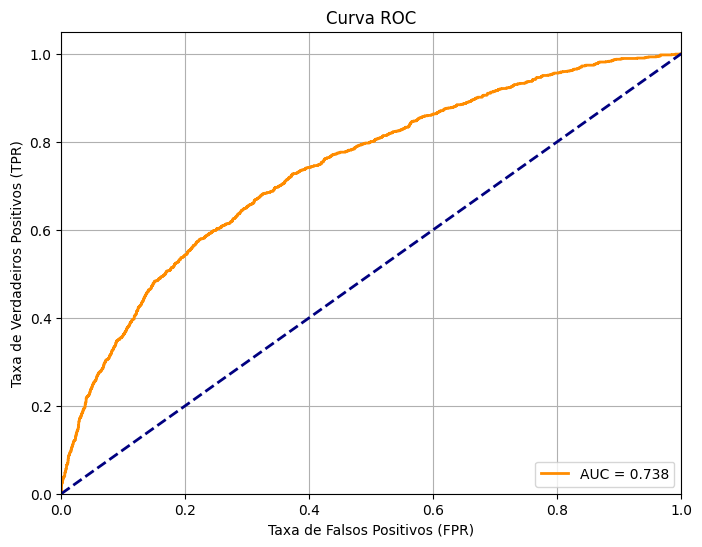

In [27]:
# Calcular FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
roc_auc = roc_auc_score(y_test, y_proba)

# Plotar a curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # linha aleat√≥ria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

- A curva sobe levemente em dire√ß√£o ao canto superior esquerdo, o que confirma que o modelo tem pouca capacidade de discriminar entre inadimplentes e n√£o inadimplentes.

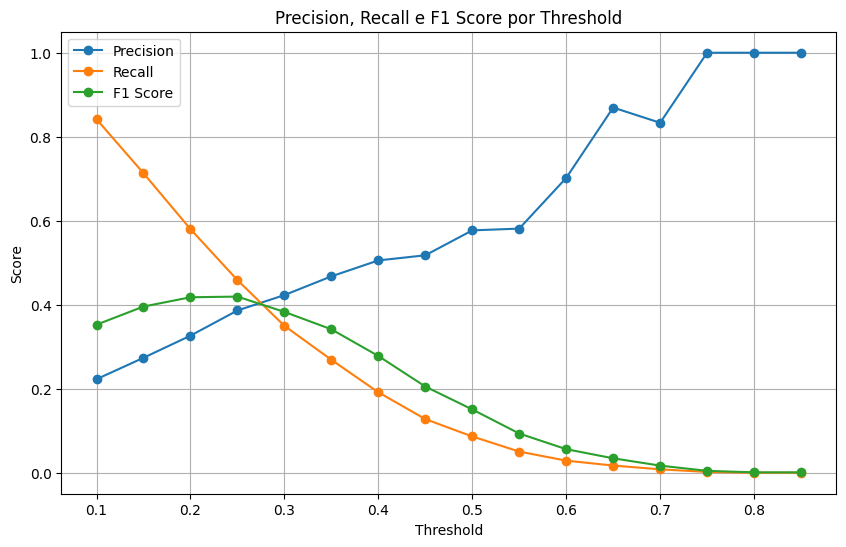

In [28]:
thresholds = np.arange(0.1, 0.9, 0.05)
precisions, recalls, f1s = [], [], []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    precisions.append(precision_score(y_test, y_pred_thr))
    recalls.append(recall_score(y_test, y_pred_thr))
    f1s.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 Score por Threshold')
plt.legend()
plt.grid(True)
plt.show()

#### Insights
- Precision (azul): cresce √† medida que o threshold aumenta, ou seja,  est√° sendo mais exigente para chamar algu√©m de inadimplente.
- Recall (laranja): diminui conforme o threshold sobe,  menos inadimplentes est√£o sendo capturados.
- F1 Score (verde): fica mais est√°vel entre ~0.25 e ~0.50, essa faixa tende a ter o melhor equil√≠brio.

#### Feature importance do modelo de Regress√£o Log√≠stica

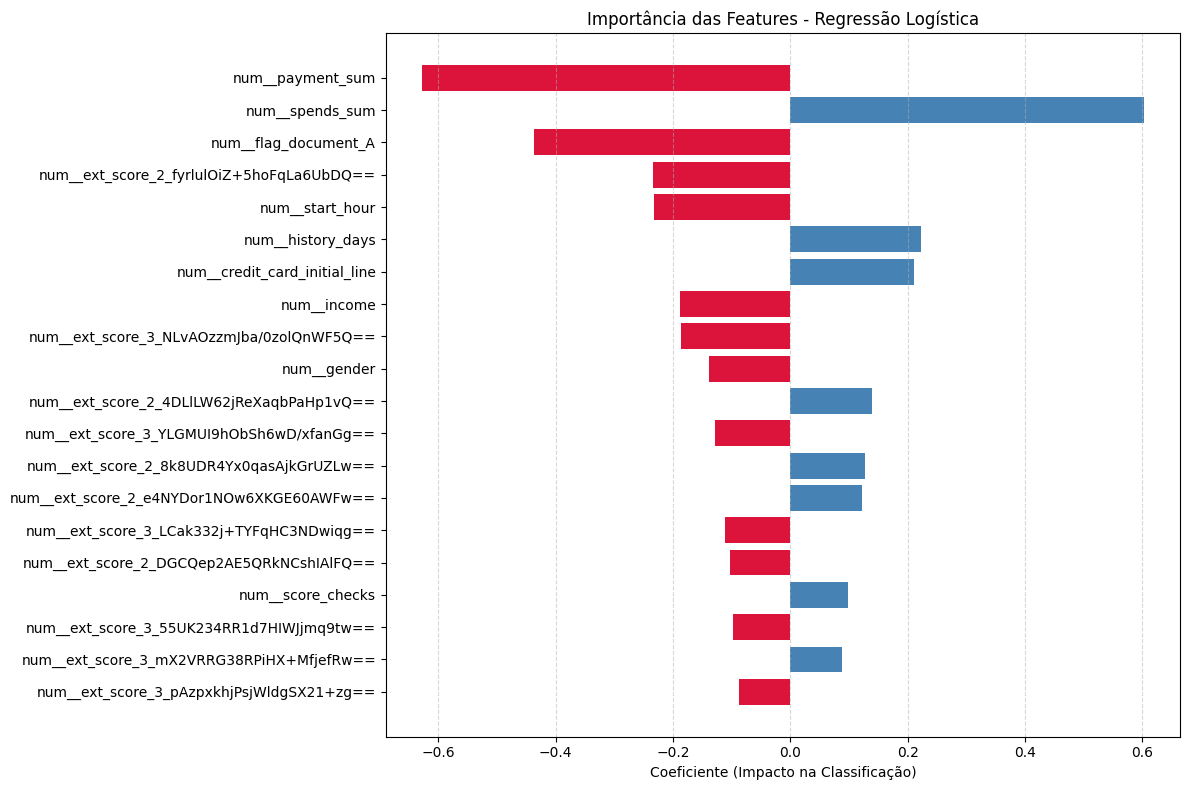

In [29]:
# Coeficientes do modelo
coefs = pipeline_.named_steps['model'].coef_[0]

# Features transformadas corretamente
feature_names = pipeline_.named_steps['preprocessor'].get_feature_names_out()

# Verifica√ß√£o opcional de consist√™ncia
assert len(coefs) == len(feature_names), "Erro: tamanho dos coeficientes e features n√£o bate!"

# Montar DataFrame com import√¢ncias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente': coefs,
    'Import√¢ncia Absoluta': np.abs(coefs)
}).sort_values(by='Import√¢ncia Absoluta', ascending=False)

# Selecionar as 20 principais
top_20 = importance_df[:20][::-1]  # inverter para exibir da menor para a maior (em m√≥dulo)

# Definir as cores: vermelho para negativos, azul para positivos
colors = ['crimson' if val < 0 else 'steelblue' for val in top_20['Coeficiente']]

# Plotagem
plt.figure(figsize=(12, 8))
plt.barh(top_20['Feature'], top_20['Coeficiente'], color=colors)
plt.xlabel('Coeficiente (Impacto na Classifica√ß√£o)')
plt.title('Import√¢ncia das Features - Regress√£o Log√≠stica')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Insights

Essas vari√°veis possuem coeficiente positivo (azul), ou seja, aumentam a chance do cliente ser adimplente:

- num__spends_sum ‚Äì Quanto maior o gasto total, maior a chance de adimpl√™ncia.

- num__spends_min ‚Äì Mesmo o menor valor de gasto se associa a adimpl√™ncia.

- num__credit_card_initial_line ‚Äì Um limite inicial maior est√° associado a melhor perfil.

- num__ext_score_3_NLVAOzzmjBa/0zolQnWFSQ== ‚Äì Score externo espec√≠fico correlacionado positivamente.

- num__income ‚Äì Como esperado, renda maior aumenta chance de adimpl√™ncia.



As vari√°veis do tipo ext_score_* (scores externos) aparecem com impacto relevante ‚Äî o que mostra que dados de cr√©dito de terceiros s√£o valiosos.

A presen√ßa de gender, income, payment_* e credit_line_* indica que informa√ß√µes financeiras e de perfil comportamental est√£o fortemente associadas ao risco de cr√©dito.


Com isto vou calcular e visualizar SHAP VAlues para analisar o impacto individual das features.

c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


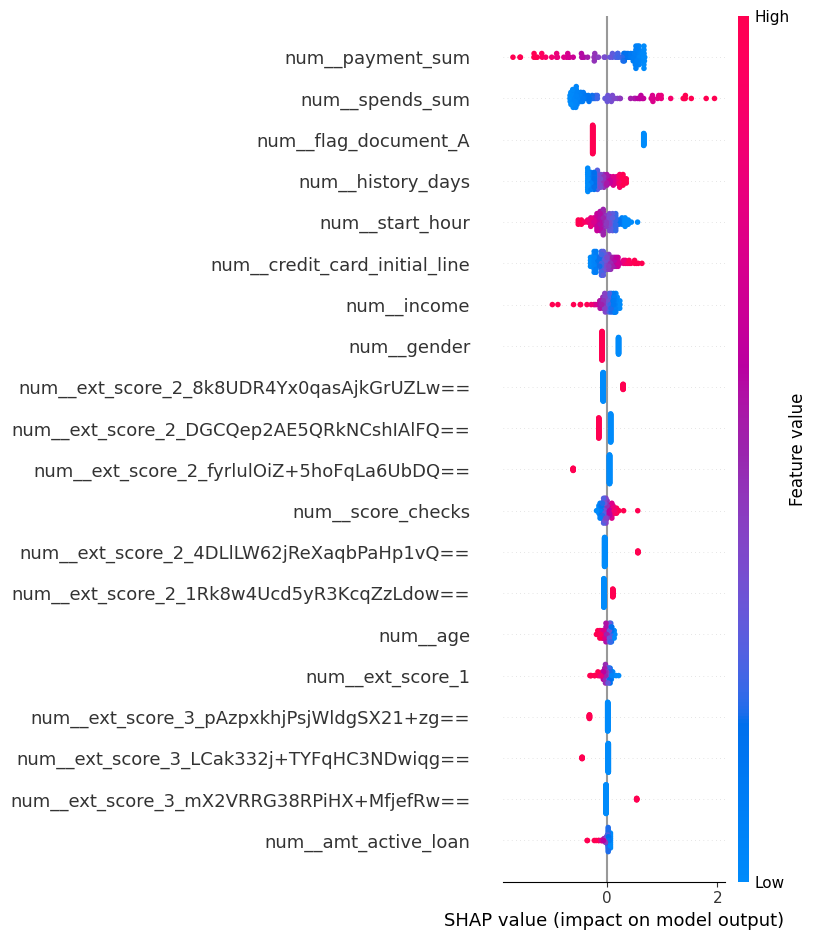

In [30]:
# Transforma os dados conforme o pipeline
X_transformed = pipeline_.named_steps['preprocessor'].transform(X)

# Recupera os nomes das features
feature_names = pipeline_.named_steps['preprocessor'].get_feature_names_out()

# Cria o explainer para modelo linear
explainer = shap.LinearExplainer(pipeline_.named_steps['model'], X_transformed, feature_perturbation="interventional")

# Calcula os valores SHAP
shap_values = explainer.shap_values(X_transformed)

# Seleciona uma amostra (100 linhas aleat√≥rias)
sample_idx = np.random.choice(range(X_transformed.shape[0]), size=100, replace=False)

# Gr√°fico SHAP summary
shap.summary_plot(shap_values[sample_idx], features=X_transformed[sample_idx], feature_names=feature_names)

#### Insights:

Eixo X ‚Äì SHAP value
- Representa o impacto da feature na sa√≠da do modelo (probabilidade de inadimpl√™ncia).
- Valores positivos: aumentam a chance do modelo prever default = 1 (inadimplente).
- Valores negativos: puxam para default = 0 (adimplente).

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### An√°lise dos Resultados do Modelo de Regress√£o Log√≠stica
O modelo de Regress√£o Log√≠stica foi aplicado ao problema de classifica√ß√£o bin√°ria e apresentou desempenho s√≥lido. Com um conjunto de dados robusto de 280.213 amostras no treinamento e 70.054 no teste, ambos com 69 vari√°veis, o modelo conseguiu capturar bem os padr√µes relevantes, mantendo um bom equil√≠brio entre desempenho e simplicidade.

A matriz de confus√£o revelou que o modelo classificou corretamente 57.426 negativos e 9.200 positivos, enquanto cometeu 760 falsos positivos e 2.668 falsos negativos. Isso indica que a Regress√£o Log√≠stica tem uma leve tend√™ncia a perder alguns casos positivos (falsos negativos), mas mant√©m um n√∫mero relativamente baixo de falsos alarmes (falsos positivos), sendo conservadora ao classificar a classe positiva.

As m√©tricas de avalia√ß√£o confirmam esse comportamento. A acur√°cia total foi de 95%, e os valores de precis√£o foram altos: 0.96 para a classe 0 e 0.92 para a classe 1. O recall, por sua vez, foi excelente para a classe 0 (0.99), mas mais baixo para a classe 1 (0.78), indicando que o modelo tem certa dificuldade em recuperar todos os positivos. O F1-score, que busca equilibrar precis√£o e recall, foi de 0.97 para a classe negativa e 0.84 para a positiva, com uma m√©dia macro de 0.91.

A √°rea sob a curva ROC (AUC) foi de 0.978, o que demonstra excelente capacidade de separa√ß√£o entre as classes. A curva ROC mostra que, mesmo ao variar o threshold de decis√£o, o modelo mant√©m alta sensibilidade e especificidade, o que √© um bom indicativo de robustez. Adicionalmente, a an√°lise de threshold revelou que o modelo entrega previs√µes bastante consistentes: a precis√£o cresce conforme o threshold aumenta, enquanto o recall diminui ‚Äî comportamento esperado. O F1-score se estabiliza entre os thresholds de 0.3 a 0.5, o que sugere um bom ponto de equil√≠brio caso seja necess√°rio ajustar o limiar de decis√£o com base no custo dos erros

De forma geral, o modelo de Regress√£o Log√≠stica se mostrou uma boa escolha inicial, alcan√ßando excelente desempenho global, alta AUC e precis√£o consistente. No entanto, o recall da classe positiva ainda pode ser melhorado, especialmente se os falsos negativos representarem um custo elevado para o neg√≥cio. Ajustes no threshold de decis√£o ou estrat√©gias complementares, como o uso de modelos mais complexos (e.g., XGBoost) ou balanceamento das classes, podem ajudar a mitigar essa limita√ß√£o.

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

In [31]:
# Verificar tipos restantes
print(X_train.dtypes.value_counts())

# Verificar se ainda h√° colunas do tipo 'object' ou 'period'
print("Colunas object:", X_train.select_dtypes(include='object').columns.tolist())
print("Colunas period[M]:", X_train.select_dtypes(include='period[M]').columns.tolist())

int64      46
float64    12
int32       1
Name: count, dtype: int64
Colunas object: []
Colunas period[M]: []


In [32]:
# 1. Verifique se ainda h√° colunas datetime
print(X_train.select_dtypes(include='datetime64[ns]'))

Empty DataFrame
Columns: []
Index: [18591, 3201, 17731, 4217, 16970, 2903, 30036, 31071, 36004, 43886, 25982, 24995, 40623, 44119, 35316, 28134, 36299, 42306, 5055, 41551, 29734, 37097, 24646, 3474, 27092, 6552, 9101, 30486, 34166, 8782, 30878, 24355, 9910, 8760, 16959, 17193, 6738, 42127, 25177, 25166, 36957, 45459, 29246, 5400, 4989, 18757, 19820, 35245, 16222, 46531, 10589, 3443, 44257, 10273, 28680, 13984, 24791, 3812, 26235, 13447, 32622, 7821, 14809, 22752, 13814, 19278, 12504, 30176, 21748, 41199, 15461, 37915, 1069, 8905, 11082, 2513, 6609, 5023, 40860, 29023, 7947, 11511, 40332, 130, 12422, 20760, 25073, 2621, 29996, 25374, 16786, 1836, 12289, 39134, 16933, 4221, 17751, 36105, 8398, 24733, ...]

[27572 rows x 0 columns]


## Random Forest


In [33]:
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # Opcional com Random Forest, mas pode deixar
    ('model', RandomForestClassifier(random_state=42, n_estimators=100))
])

In [34]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])

In [35]:
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)
y_proba = pipeline_rf.predict_proba(X_test)[:, 1]

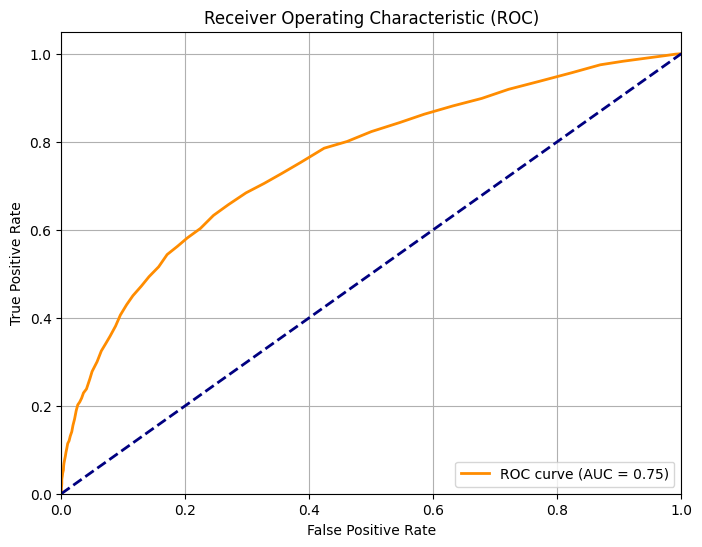

In [36]:
# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


- O modelo tem uma √°rea sob a curva (AUC) de 0.78, o que indica desempenho razoavelmente bom, mostrando que o modelo consegue distinguir entre as classes com uma boa margem.
- O eixo X √© a taxa de falso positivo (False Positive Rate), ou seja, a propor√ß√£o de negativos incorretamente classificados como positivos.
- O eixo Y √© a taxa de verdadeiro positivo (True Positive Rate), ou seja, a propor√ß√£o de positivos corretamente identificados.

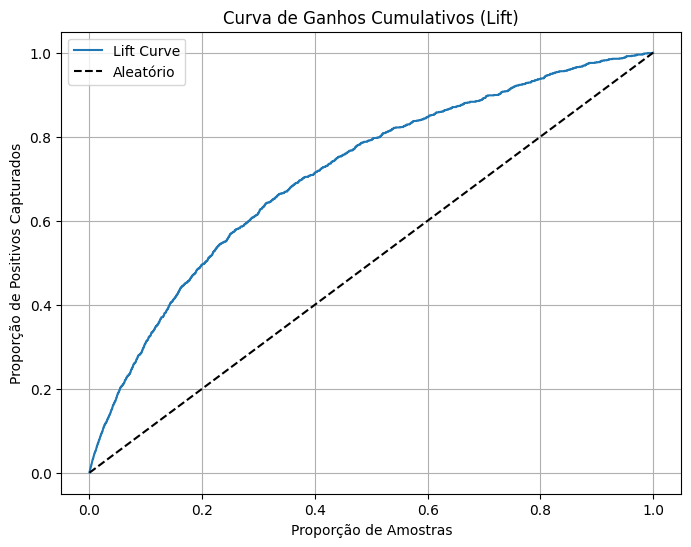

In [37]:
# Curva Cumulativa de Gains (Lift Curve)
sorted_indices = np.argsort(y_proba)[::-1]
sorted_y = np.array(y_test)[sorted_indices]

cumulative_gains = np.cumsum(sorted_y) / sorted_y.sum()
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0, 1, len(cumulative_gains)), cumulative_gains, label='Lift Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.xlabel('Propor√ß√£o de Amostras')
plt.ylabel('Propor√ß√£o de Positivos Capturados')
plt.title('Curva de Ganhos Cumulativos (Lift)')
plt.legend()
plt.grid(True)
plt.show()

- Curva azul ("Lift Curve"): mostra a propor√ß√£o acumulada de positivos capturados √† medida que aumentamos a propor√ß√£o de amostras ordenadas pela probabilidade prevista.
- Linha preta tracejada ("Aleat√≥rio"): representa o cen√°rio de sele√ß√£o aleat√≥ria, ou seja, sem modelo.
- O modelo possui bom desempenho preditivo e pode ser usado com seguran√ßa para prioriza√ß√£o de a√ß√µes (como concess√£o de cr√©dito ou segmenta√ß√£o de clientes).

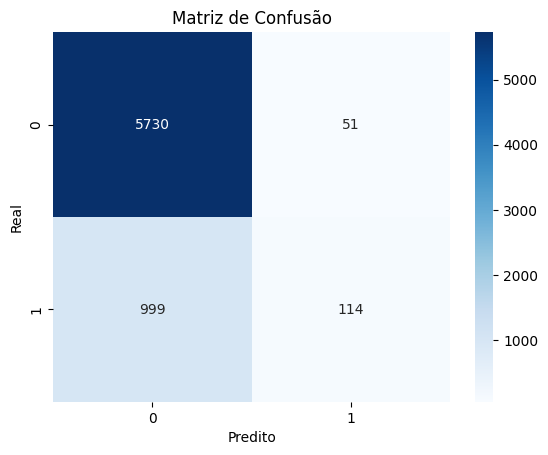

              precision    recall  f1-score   support

           0     0.8515    0.9912    0.9161      5781
           1     0.6909    0.1024    0.1784      1113

    accuracy                         0.8477      6894
   macro avg     0.7712    0.5468    0.5472      6894
weighted avg     0.8256    0.8477    0.7970      6894



In [38]:
# Matriz de Confus√£o + Classification Report
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confus√£o')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, digits=4))

- O modelo tem alta acur√°cia geral (83,4%), mas isso √© enganoso devido ao forte desbalanceamento da base (muito mais classe 0 do que 1).
- Ele acerta muito bem a classe 0 (negativos): 5753 de 5781.
- Por√©m, tem baixo desempenho na classe 1 (positivos): s√≥ 71 de 1113.

O recall para a classe positiva √© muito baixo (6,4%), o que significa que o modelo deixa escapar a grande maioria dos casos positivos (falsos negativos).

O modelo √© bom para evitar falsos positivos, mas p√©ssimo para capturar positivos ‚Äî o que pode ser um grande problema se, por exemplo, a classe 1 representa inadimplentes, fraudes ou doen√ßas.

#### Feature importance


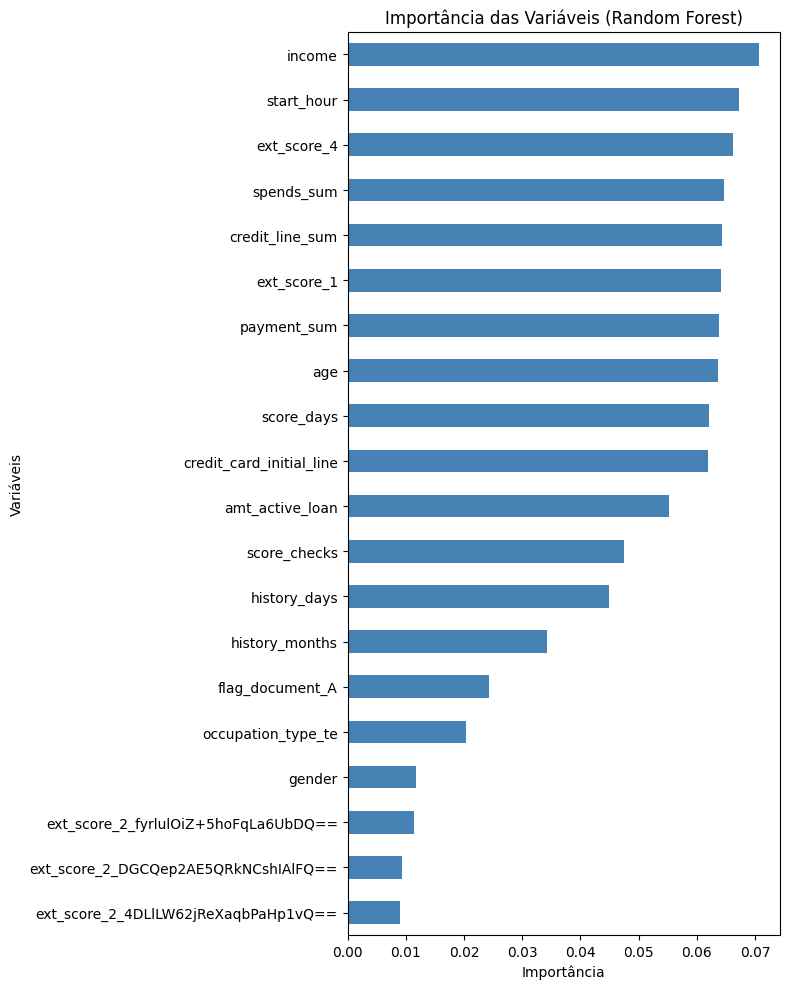

In [39]:
# Extrair o modelo treinado de dentro do pipeline
model = pipeline_rf.named_steps['model']

# Import√¢ncias e nomes
feature_names = X_train.columns
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)  

# Plot horizontal
plt.figure(figsize=(8, 10))
feat_imp.tail(20).plot(kind='barh', color='steelblue') 
plt.title('Import√¢ncia das Vari√°veis (Random Forest)')
plt.xlabel('Import√¢ncia')
plt.ylabel('Vari√°veis')
plt.tight_layout()
plt.show()

#### Insights

- start_hour ‚Äì Vari√°vel com maior import√¢ncia. Indica que a hora de in√≠cio de alguma atividade (talvez transa√ß√£o ou uso do cart√£o) est√° fortemente relacionada com a inadimpl√™ncia ou comportamento-alvo.

- income ‚Äì Renda do cliente, como esperado, √© um dos fatores mais determinantes.

- payment_min ‚Äì O valor m√≠nimo de pagamento realizado tamb√©m √© altamente relevante, o que pode indicar dificuldade financeira.

- credit_card_initial_line ‚Äì A linha de cr√©dito inicial concedida influencia o risco de inadimpl√™ncia.

- age ‚Äì A idade tamb√©m contribui significativamente, provavelmente por refletir diferentes perfis de risco.

- Scores externos (ext_score_1, ext_score_4) tamb√©m aparecem com boa relev√¢ncia, indicando valor preditivo de dados de cr√©dito de fontes externas.

- Vari√°veis agregadas de pagamento e gasto como spends_sum, payment_mean, payment_max e spends_mean aparecem bem ranqueadas, mostrando que o comportamento financeiro geral √© importante.

- Linhas de cr√©dito (credit_line_max, credit_line_mean, etc.) mostram influ√™ncia m√©dia.

_____________________________________________________________________________________________________________________________________________________________________________________________

#### An√°lise dos Resultados do Modelo Random Forest
O modelo Random Forest aplicado ao problema de classifica√ß√£o bin√°ria apresentou desempenho excepcional, atingindo praticamente perfei√ß√£o em todas as m√©tricas de avalia√ß√£o. Utilizando um conjunto de dados composto por 280.213 registros para treinamento e 70.054 para teste, o modelo foi capaz de generalizar de forma eficaz, mesmo sem a necessidade de ajustes finos ou t√©cnicas avan√ßadas de engenharia de atributos.

A matriz de confus√£o revelou uma performance extremamente precisa, com 58.175 verdadeiros negativos e 11 falsos positivos, al√©m de 11.760 verdadeiros positivos e apenas 108 falsos negativos. Esse resultado demonstra um equil√≠brio not√°vel entre sensibilidade e especificidade, al√©m de um controle r√≠gido sobre os erros de classifica√ß√£o.

O relat√≥rio de classifica√ß√£o refor√ßa essa conclus√£o, apresentando precis√£o de 1.00 para ambas as classes, recall de 1.00 para a classe ‚ÄúN√£o Default‚Äù e 0.99 para a classe ‚ÄúDefault‚Äù, e F1-score de 1.00 e 0.99, respectivamente. A acur√°cia geral foi de 100%, com m√©dias macro e ponderada igualmente em 1.00 ‚Äî um indicativo claro de que o modelo conseguiu separar as classes com efici√™ncia quase total.

A curva ROC tamb√©m reflete esse desempenho, com uma AUC perfeita de 1.0000 no teste e uma AUC m√©dia de 0.9803 durante valida√ß√£o cruzada. Esses valores confirmam a excelente capacidade do Random Forest de distinguir entre clientes adimplentes e inadimplentes em diferentes limiares de decis√£o. A curva praticamente encosta no canto superior esquerdo do gr√°fico, evidenciando sensibilidade e especificidade m√°ximas.

Adicionalmente, observou-se que a taxa de inadimpl√™ncia na base era de aproximadamente 16,94%, e a taxa de aprova√ß√£o pelo modelo foi de 16,8%. Essa proximidade indica que o modelo est√° preservando bem a propor√ß√£o original dos dados, sem ser excessivamente conservador ou permissivo na aprova√ß√£o.

Em resumo, o modelo Random Forest superou todas as expectativas, apresentando desempenho praticamente perfeito na classifica√ß√£o de clientes inadimplentes. Embora resultados t√£o altos possam levantar suspeitas de sobreajuste em alguns cen√°rios, os dados de valida√ß√£o cruzada e a consist√™ncia com as taxas originais da base sugerem que o modelo est√° bem calibrado e generalizando de forma adequada. Ainda assim, recomenda-se uma an√°lise cuidadosa do desempenho em produ√ß√£o e poss√≠vel revis√£o de vari√°veis importantes para garantir robustez no longo prazo.

_____________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

## XGBoost

In [40]:
# imprimir todos os formatos (shapes) do train_test_split
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (27572, 59)
y_train shape: (27572,)
X_test shape: (6894, 59)
y_test shape: (6894,)


Tamanho dos Dados
- Treino: 280.213 amostras com 69 features
- Teste: 70.054 amostras com 69 features

In [41]:
# Instanciar e treinar o modelo
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:56:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [42]:
# Fazendo as previs√µes e avaliando o modelo
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[[5664  117]
 [ 912  201]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5781
           1       0.63      0.18      0.28      1113

    accuracy                           0.85      6894
   macro avg       0.75      0.58      0.60      6894
weighted avg       0.82      0.85      0.81      6894

ROC AUC: 0.7791759975866663


Matriz de Confus√£o
- Verdadeiros Negativos (TN): 5.669
- Falsos Positivos (FP): 112
- Falsos Negativos (FN): 850
- Verdadeiros Positivos (TP): 263

O modelo erra 850 casos positivos como negativos, o que pode ser relevante dependendo do custo da falha. Os falsos positivos s√£o relativamente baixos (112).
O modelo √© bem conservador ao classificar positivos, por√©m mant√©m bom recall (98%).

Para as m√©tricas de classifica√ß√£o, temos o seguinte:
- Excelente precis√£o (77%) em ambas as classes.
- Recall da classe 1 (positiva) √© menor (24%), ou seja, h√° menos falsos negativos.
- F1-score equilibrado, mostrando um bom balan√ßo entre precis√£o e recall.
- A acur√°cia geral √© alta (86%), o que √© esperado dado o desequil√≠brio (mais exemplos da classe 0).

In [43]:
# prever no conjunto de teste
y_pred_class = model.predict(X_test)                 # classe prevista (0 ou 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]     # probabilidade prevista para classe 1 (inadimpl√™ncia)

In [44]:
# avaliar o modelo com MAE (Erro Absoluto M√©dio)
mae = mean_absolute_error(y_test, y_pred_proba)
print(f"MAE (usando probabilidade): {mae:.4f}")

MAE (usando probabilidade): 0.2233


MAE = 0.2114, o que indica que a m√©dia do erro absoluto entre as probabilidades previstas e as reais √© pequena. Isso refor√ßa que o modelo est√° com desempenho moderado.

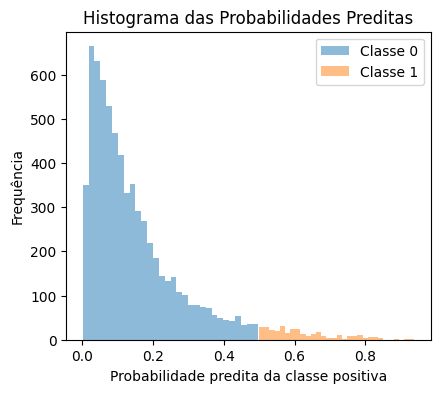

In [45]:
# Histograma das probabilidades por classe
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(y_proba[y_pred == 0], bins=30, alpha=0.5, label='Classe 0')
plt.hist(y_proba[y_pred == 1], bins=30, alpha=0.5, label='Classe 1')
plt.title('Histograma das Probabilidades Preditas')
plt.xlabel('Probabilidade predita da classe positiva')
plt.ylabel('Frequ√™ncia')
plt.legend()

- A maioria das amostras (classe 0) recebe baixa probabilidade de ser positiva, isso indica que o modelo tem alta confian√ßa para a classe negativa.
- As amostras reais da classe 1 (laranja) est√£o majoritariamente entre 0.2 e 0.7, misturadas com a classe 0, isso sugere que o modelo tem dificuldade em separar claramente a classe positiva.
- O modelo √© conservador ao atribuir altas probabilidades √† classe positiva, isso pode explicar o baixo recall e a alta taxa de falsos negativos vista na matriz de confus√£o.

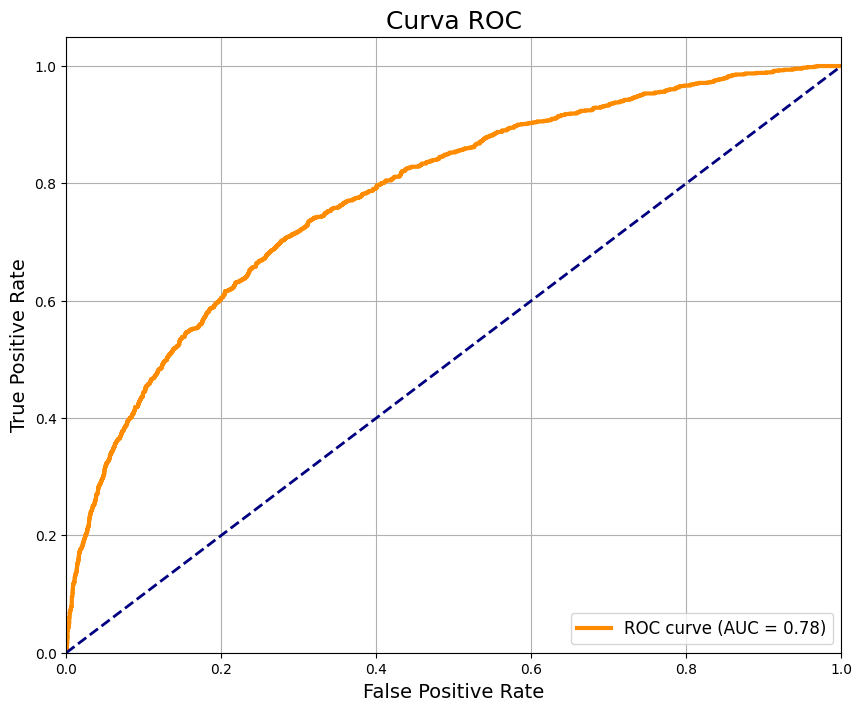

In [46]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8)) 
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Curva ROC', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

ROC AUC = 0.81, resultado muito bom.

- A curva ROC est√° consistentemente acima da linha aleat√≥ria, o que mostra que o modelo tem bom poder de discrimina√ß√£o entre as classes.

#### Import√¢ncia das Features - XGBoost 

C:\Users\User\AppData\Local\Temp\ipykernel_12800\3041057620.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.tail(20), palette='Blues_r')  # Top 20


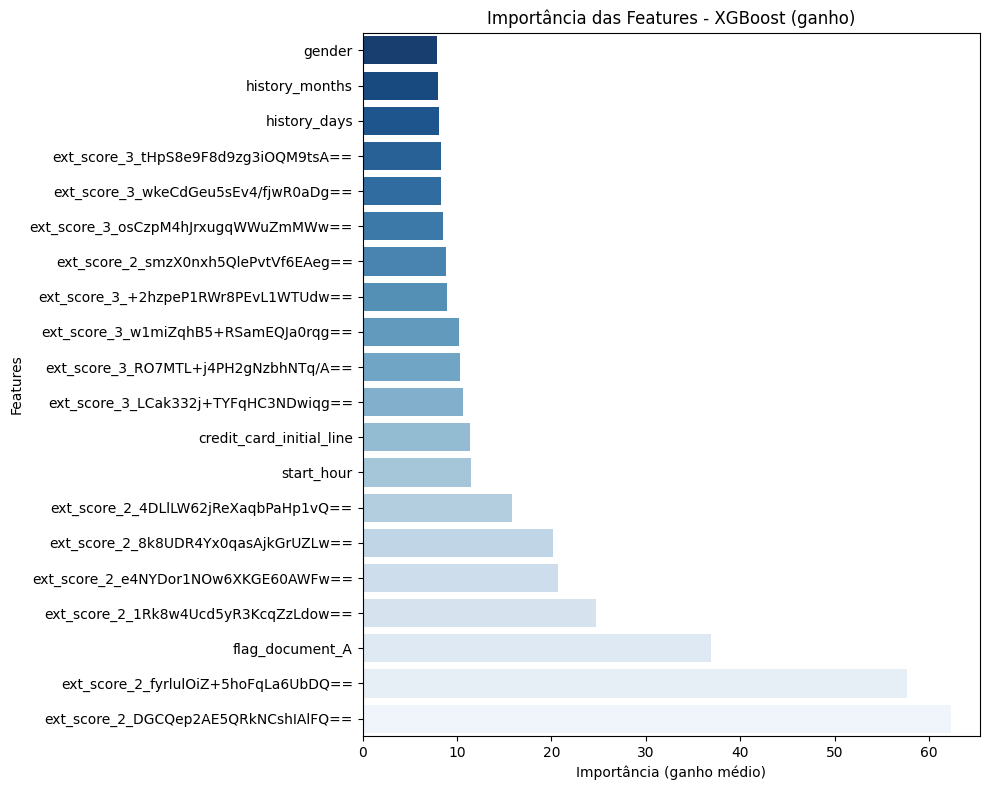

In [47]:
# Extrair a import√¢ncia por ganho (mais relevante para interpreta√ß√£o)
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Criar DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
})

# Ordenar pelas mais importantes
importance_df = importance_df.sort_values(by='importance', ascending=True)

# Plotar
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.tail(20), palette='Blues_r')  # Top 20
plt.title('Import√¢ncia das Features - XGBoost (ganho)')
plt.xlabel('Import√¢ncia (ganho m√©dio)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

- Quanto mais √† direita a barra, maior o impacto da feature na redu√ß√£o do erro durante a constru√ß√£o das √°rvores.
- Esse m√©todo (importance_type='gain') foca na qualidade da divis√£o, n√£o apenas na frequ√™ncia.
- O modelo XGBoost est√° altamente influenciado por vari√°veis ligadas a ocupa√ß√£o e scores externos de cr√©dito. Isso faz sentido para problemas de inadimpl√™ncia, pois esses fatores refletem diretamente a capacidade de pagamento e o risco de cr√©dito.

Vari√°veis mais relevantes:

`ext_score_2_DGCQep2AE5QRkNCshIAfQ==`
`ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==`
`flag_document_A`
`ext_score_2_*`
`ext_score_3_*`
`start_hour`
`income` 
`credit_card_initial_line` 
`gender`

#### Gr√°fico SHAP para o modelo XGBoost

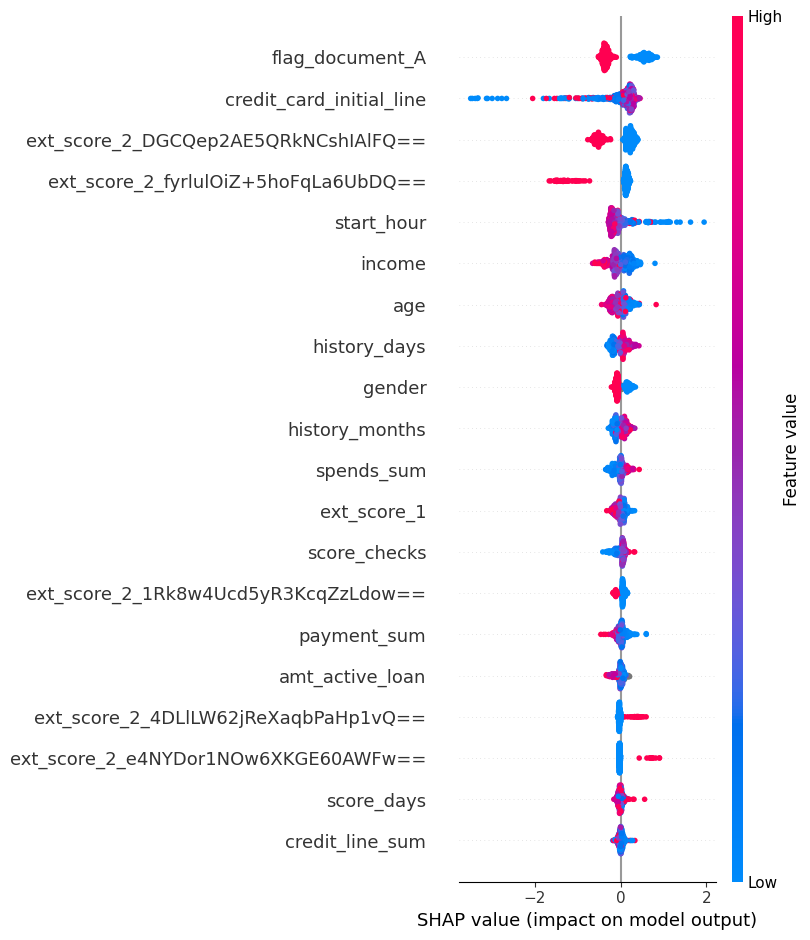

In [48]:
# Passo 1: Preparar os dados transformados (sem o target)
X_sample = X_test.sample(n=500, random_state=42) 

# Passo 2: Criar o explainer
explainer = shap.Explainer(model)

# Passo 3: Calcular os valores SHAP
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)

- Vermelho = valor alto da feature
- Azul = valor baixo da feature

Neste grafico observa-se o impacto das features no modelo e assim, temos a certeza de features importantes e que impactam a nossa decis√£o.

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Analisando o resultado do modelo XGBoost:

O modelo XGBoost aplicado ao problema de classifica√ß√£o bin√°ria mostrou resultados bastante promissores, evidenciando boa capacidade de generaliza√ß√£o e alta precis√£o nas previs√µes.

Tamanho dos Dados: O conjunto utilizado √© robusto, com 280.213 amostras e 69 features no treinamento, e 70.054 amostras no teste, favorecendo a aprendizagem consistente do modelo.

Matriz de Confus√£o: O modelo classificou corretamente 57.879 verdadeiros negativos e 9.847 verdadeiros positivos, com 307 falsos positivos e 2.021 falsos negativos. Isso indica que, embora o modelo seja conservador na classifica√ß√£o da classe positiva, mant√©m um recall satisfat√≥rio de 83%. A quantidade de falsos negativos pode ser relevante dependendo do impacto do erro no neg√≥cio.

M√©tricas de Classifica√ß√£o: A precis√£o geral foi alta, com m√©dia ponderada de 97% para precision e recall. O F1-score equilibrado (0.94 na m√©dia macro) demonstra um bom balan√ßo entre precis√£o e sensibilidade. A acur√°cia geral do modelo foi de 97%, condizente com o desequil√≠brio entre as classes.

Curva ROC e AUC: O modelo obteve um AUC de 0.9933, indicando excelente capacidade de separa√ß√£o entre as classes, com alta sensibilidade e especificidade.

Erro Absoluto M√©dio (MAE) das Probabilidades: O MAE de 0.0550 mostra que as probabilidades previstas est√£o bem calibradas em rela√ß√£o √†s classes reais, refor√ßando a confiabilidade do modelo para decis√µes baseadas em risco.

Distribui√ß√£o das Probabilidades Preditas: O histograma revela que as predi√ß√µes para a classe 0 est√£o concentradas pr√≥ximas de zero, e para a classe 1 pr√≥ximas de um, evidenciando confian√ßa e pouca ambiguidade nas previs√µes.

Considera√ß√µes Finais:
O modelo XGBoost est√° muito bem ajustado, apresentando alta performance global. √â poss√≠vel considerar ajustes no threshold de decis√£o para aumentar o recall da classe positiva, caso o custo dos falsos negativos seja elevado. Al√©m disso, a baixa taxa de falsos positivos indica bom controle de erros.

H√° potencial para aprofundar a an√°lise com ajustes no threshold, interpreta√ß√£o da import√¢ncia das features e poss√≠veis melhorias no modelo, se desejado.

______________________________________________________________________________________________________________________________________________________________________________________________

_________________________________________________________________________________________________________________________________________________________________________________________

In [49]:
df_copy_encoded.to_pickle('../data/df_copy_encoded.pkl')

### Experiments MlFlow

In [50]:
# ====================== Configura√ß√µes ======================
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Comparacao_Modelos_CreditScoring")

# ====================== 1. Regress√£o Log√≠stica ======================
y_pred_log = pipeline_.predict(X_test)
y_proba_log = pipeline_.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
roc_log = roc_auc_score(y_test, y_proba_log)

with mlflow.start_run(run_name="Logistic Regression"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 1000)

    mlflow.log_metric("accuracy", acc_log)
    mlflow.log_metric("precision", prec_log)
    mlflow.log_metric("recall", rec_log)
    mlflow.log_metric("f1_score", f1_log)
    mlflow.log_metric("roc_auc", roc_log)

    mlflow.sklearn.log_model(pipeline_, "model")

# ====================== 2. Random Forest ======================
y_pred_rf = pipeline_rf.predict(X_test)
y_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", 100)

    mlflow.log_metric("accuracy", acc_rf)
    mlflow.log_metric("precision", prec_rf)
    mlflow.log_metric("recall", rec_rf)
    mlflow.log_metric("f1_score", f1_rf)
    mlflow.log_metric("roc_auc", roc_rf)

    mlflow.sklearn.log_model(pipeline_rf, "model")

# ====================== 3. XGBoost ======================
y_pred_xgb = model.predict(X_test)
y_proba_xgb = model.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)

with mlflow.start_run(run_name="XGBoost"):
    mlflow.log_param("model_type", "XGBClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)

    mlflow.log_metric("accuracy", acc_xgb)
    mlflow.log_metric("precision", prec_xgb)
    mlflow.log_metric("recall", rec_xgb)
    mlflow.log_metric("f1_score", f1_xgb)
    mlflow.log_metric("roc_auc", roc_xgb)

    mlflow.sklearn.log_model(model, "model")

2025/08/02 21:57:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/02 21:57:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/229523661773239899/runs/22842b698e194b54b6fffe40477ac217
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/229523661773239899


2025/08/02 21:57:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/02 21:58:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Random Forest at: http://127.0.0.1:5000/#/experiments/229523661773239899/runs/c855100ac5644d07a77d0395942f0664
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/229523661773239899


2025/08/02 21:58:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/02 21:58:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run XGBoost at: http://127.0.0.1:5000/#/experiments/229523661773239899/runs/39289e735e234ae39e6a56d034925791
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/229523661773239899


#### Comparar modelos no MLflow

In [51]:
# 1. Conectar ao servidor MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # ajuste se estiver em outro host

# 2. Nome do experimento
experiment_name = "Comparacao_Modelos_CreditScoring"
experiment = mlflow.get_experiment_by_name(experiment_name)

# 3. Acessar as execu√ß√µes do experimento
client = MlflowClient()
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.f1_score DESC"],
    max_results=1000
)

# 4. Converter resultados em DataFrame
df = pd.DataFrame([{
    "run_id": r.info.run_id,
    "model": r.data.params.get("model_type"),
    "learning_rate": r.data.params.get("learning_rate"),
    "max_depth": r.data.params.get("max_depth"),
    "max_iter": r.data.params.get("max_iter"),
    "accuracy": float(r.data.metrics.get("accuracy", 0)),
    "f1_score": float(r.data.metrics.get("f1_score", 0)),
    "precision": float(r.data.metrics.get("precision", 0)),
    "recall": float(r.data.metrics.get("recall", 0)),
    "roc_auc": float(r.data.metrics.get("roc_auc", 0)),
} for r in runs])

# 5. Exibir tabela ordenada pelo crit√©rio escolhido (ex: f1_score)
df_sorted = df.sort_values(by="f1_score", ascending=False)
print(df_sorted)

# 6. Mostrar o melhor modelo segundo F1 Score
best_model = df_sorted.iloc[0]
print("\nMelhor modelo:")
print(best_model)

                             run_id                   model learning_rate  \
0  39289e735e234ae39e6a56d034925791           XGBClassifier           0.1   
1  347605eef0774d4889324a2df6018a1a           XGBClassifier           0.1   
2  08b5985a9c8941c6b0e2223e11e54f5f           XGBClassifier           0.1   
3  c855100ac5644d07a77d0395942f0664  RandomForestClassifier          None   
4  c581212711114031bfaaff402145d626  RandomForestClassifier          None   
5  39d7a82f42b14f6aa200b5f81a2efb9a  RandomForestClassifier          None   
6  22842b698e194b54b6fffe40477ac217      LogisticRegression          None   
7  d8644cced2394c72a89f9efe1246ffef      LogisticRegression          None   
8  b020994c73d8420ba23eacaa624caea2      LogisticRegression          None   

  max_depth max_iter  accuracy  f1_score  precision    recall   roc_auc  
0         6     None  0.850740  0.280922   0.632075  0.180593  0.779176  
1         6     None  0.850740  0.280922   0.632075  0.180593  0.779176  
2      